In [2]:
!pip install pca
!pip install fredapi

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import yfinance as yf
from sklearn import svm
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, Ridge, LinearRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score, mean_squared_error, precision_score, r2_score, recall_score, roc_auc_score, roc_curve, silhouette_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler, label_binarize
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage

# Issue 1: Optimizing Hyperparameters

## How to Optimize Hyperparameters

Hyperparameters vary with different models.

- The first steps to optimizing hyperparameters is to identify the model in question: Is it a Supervised machine learning models (Classifiers, Regressors), Unsupervised learning model or Neural Network.

- Secondly, Identify all of the relevant hyperparameters associated with the model in question.

- Specify a search range for the parameters for tuning

- For a supervised model, apply optimization algorithm search (e.g GridSearch, K-fold cross validation) to determine best parameters for the models. While for an unsupervised model implement a manual search function on the search range.

- Apply the best hyperparameters in the modelling operations.

- Evaluate the model perfromance by using metrics such as Mean-Squared Error, R-squared value, Classification report depending on kind of model - measures its accuracy

For this python code, we will show how to optimize hyparameters for unsupervised learning models, supervised learning models, Combination of both learning models (in an ML pipeline) and Neural Networks.



## Unsupervised Learning Models

### Hierarchical Clustering

There are 3 main hyperparamters that can be tuned in hierarchical clustering model(say, an Agglomerative Clustering problem), these parameters are namely:

- n_clusters: number of clusters
- linkage method: which measures how to compute distance between clusters. Linkage methods could be ward, complete, average, single
- distance metric: euclidean, manhattan etc.

In [4]:
 # Defining the date range for daily data from 2018 to 2023
start_date = "2018-01-01"
end_date   = "2023-12-31"

# Downloading historical data for SPY (S&P 500 ETF) and QQQ (Nasdaq-100 ETF)
spy_data  = yf.download("SPY", start=start_date, end=end_date)
qqq_data  = yf.download("QQQ", start=start_date, end=end_date)

# Debug: Print the column names to verify available columns
print("SPY Data Columns:", spy_data.columns)
print("QQQ Data Columns:", qqq_data.columns)

# Using the 'Adj Close' column if available; otherwise, fallback to 'Close'
spy_col = "Adj Close" if "Adj Close" in spy_data.columns else "Close"
qqq_col = "Adj Close" if "Adj Close" in qqq_data.columns else "Close"

# Creating DataFrames for the selected columns
spy_df = pd.DataFrame(spy_data[spy_col], columns=["SPY"])
qqq_df = pd.DataFrame(qqq_data[qqq_col], columns=["QQQ"])

# Merge the DataFrames on the date index and drop rows with missing values
indices_df = pd.merge(spy_df, qqq_df, left_index=True, right_index=True, how="inner").dropna()
if indices_df.empty:
    raise ValueError("Merged DataFrame is empty. Check the date range and ticker symbols.")

# -------------------------------
# Data Preprocessing
# -------------------------------
# Standardizing the data so both SPY and QQQ are on the same scale
scaler = StandardScaler()
scaled_data = scaler.fit_transform(indices_df)
X = pd.DataFrame(scaled_data, columns=indices_df.columns, index=indices_df.index)

# Manual Grid Search + Sillhoutte Score Analysis to determine the optimal linkage method, metric and n_clusters
linkage_options = ['ward', 'complete', 'average']
n_clusters_range = range(2, 10)

best_score = -1
best_params = None

for linkage_method in linkage_options:
    for k in n_clusters_range:
        if linkage_method == 'ward':
            metric = 'euclidean'
        else:
            metric = 'manhattan'

        model = AgglomerativeClustering(n_clusters=k, linkage=linkage_method, metric=metric,  distance_threshold=None,compute_full_tree='auto', compute_distances=False)
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)

        if score > best_score:
            best_score = score
            best_params = (k, linkage_method, metric)

print("Best params:", best_params)
print("Best (Silhouette), Score", best_score)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


SPY Data Columns: MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])
QQQ Data Columns: MultiIndex([( 'Close', 'QQQ'),
            (  'High', 'QQQ'),
            (   'Low', 'QQQ'),
            (  'Open', 'QQQ'),
            ('Volume', 'QQQ')],
           names=['Price', 'Ticker'])
Best params: (2, 'complete', 'manhattan')
Best (Silhouette), Score 0.7027569580923678


Silhouette score of 0.70 and above depicts an excellent hierarchical clustering

### Principal Component Analysis

There is only one main hyperparameter that can be tuned in Principal Coomponent Analysis problem which is the **number of components (n_components)**

There are 3 commons ways for optimizing number components:
- Specify Standard Explained variance: This helps tailor the model to only work with optimal number of components required for dimensionality reduction. A standard explained variance for a principal component should be greater or equal to 95%.
- Scree plot to visualise number of components with explained variance greater than a threshold value (preferaly 95%)
- Run a GridSearch or Randomized Search or a search specific to the model in question to determine the optimal number of components. Used when PCA is integrated in a pipeline with supervised learning tasks. For this case, we'll make use of LassoCV (as this was one of the models run in GWP1)



In [5]:

from pca import pca
# Load in data from FRED Economics, drop null values
import pandas_datareader.data as web
import datetime
from datetime import datetime
import scipy as sp

# Plotting
import seaborn as sns
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from fredapi import Fred

fred = Fred(api_key="4a686e78f0f4f1b2a194e90961e4c4f9")

 Optimal number of components selected: 2


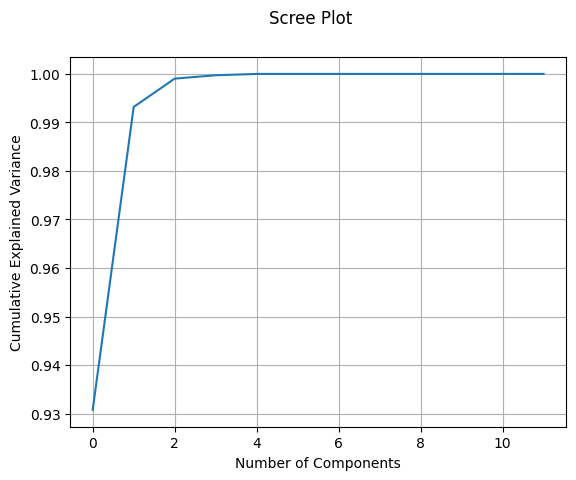

In [6]:
#Load 20-year spot rate data
start = datetime(1992, 12, 31)
end = datetime(2022, 12, 31)
data = [
    "HQMCB1YR",
    "HQMCB2YR",
    "HQMCB3YR",
    "HQMCB5YR",
    "HQMCB7YR",
    "HQMCB10YR",
    "HQMCB15YR",
    "HQMCB20YR",
    "HQMCB25YR",
    "HQMCB30YR",
    "HQMCB40YR",
    "HQMCB50YR",
]
data = web.DataReader(data, "fred", start, end).dropna(how="all").ffill()

data.rename(
    columns={
        "HQMCB1YR": "1y",
        "HQMCB2YR": "2y",
        "HQMCB3YR": "3y",
        "HQMCB5YR": "5y",
        "HQMCB7YR": "7y",
        "HQMCB10YR": "10y",
        "HQMCB15YR": "15y",
        "HQMCB20YR": "20y",
        "HQMCB25YR": "25y",
        "HQMCB30YR": "30y",
        "HQMCB40YR": "40y",
        "HQMCB50YR": "50y",
    },
    inplace=True,
)
df = data.copy()

# Rescale data
scaler = StandardScaler().fit(df)
rescaleddf = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
# summarize transformed data
df.dropna(how="any", inplace=True)
rescaleddf.dropna(how="any", inplace=True)

pca = PCA(n_components=0.95)  # keep 95% of variance
X_pca = pca.fit_transform(rescaleddf)

# 1. Specifying Standard Explained Variance (of 95%)

print(f" Optimal number of components selected: {pca.n_components_}")

# 2. Scree plot
pca = PCA().fit(rescaleddf)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.suptitle('Scree Plot')
plt.grid(True)
plt.show()

Scree plot also shows optimal number of components.

In [7]:
# 3. Pipeline Implementation (PCA + LassoCV)

# Download data
tickers = ['SPY', '^VIX', '^TNX', 'GLD', 'USO', 'TIP', 'XLY', '^IXIC', 'EURUSD=X', 'VNQ', 'XLF', 'MINT', 'XME']
data = yf.download(tickers, start='2010-01-01', end='2025-01-01')['Close']

# Compute returns (using 1-day returns)
returns = data.pct_change().shift(-1).dropna()

# Feature matrix X (including the new macroeconomic variables)
X = returns[['^VIX', '^TNX', 'GLD', 'USO', 'TIP', 'XLY', '^IXIC', 'EURUSD=X', 'VNQ', 'XLF', 'MINT', 'XME']]
# Target variable Y (future returns of SPY)
y = returns['SPY']
# Drop NaN values
X = X.dropna()
y = y.loc[X.index]

# Train-test split (ensure data is in chronological order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Pipeline: StandardScaler → PCA → LassoCV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Keep 95% variance
    ('lasso', LassoCV(alphas=np.logspace(-6, 6, 13), cv=5, random_state=42)) #cv is the number of cross va;lidation steps
])

# Fit pipeline
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluate model accuracy
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"R^2: {r2:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Best Alpha (λ): {pipeline.named_steps['lasso'].alpha_}")
print(f"Number of PCA components used: {pipeline.named_steps['pca'].n_components_}")

[*********************100%***********************]  13 of 13 completed
<ipython-input-7-f76a9c97d7fd>:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().shift(-1).dropna()


R^2: 0.930
Test RMSE: 0.003
Best Alpha (λ): 1e-06
Number of PCA components used: 9


Compared to results obtained in GWP1 where we ran Lasso cross validation on the same dataset, we obtained almost similar results for the Root mean Sqaure Error (RMSE), R-squared value  and Optimal Alpha when we integrated PCA in the same pipeline with LassoCv.  However, runnning a *cross validation* on a supervised model (LASSO Regression) is enough to optimize hyperparameters of supervised learning model.

## Supervised Models

### Linear Discriminant Analysis

In [8]:
# Define the tickers and FRED series
tickers = ['^GSPC', '^NDX', '^VIX', '^TNX', 'GC=F', 'BTC-USD']
fred_series = {'FFR': 'FEDFUNDS', 'Baa_Yield': 'BAA', 'Aaa_Yield': 'AAA'}

# Define the date range
start_date = '2010-01-01'
end_date = '2025-01-01'

# Function to fetch data from Yahoo Finance
def fetch_yahoo_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)['Close']
    return data

# Function to fetch data from FRED
def fetch_fred_data(series_dict, start, end):
    data = pd.DataFrame()
    for name, series_id in series_dict.items():
        series_data = fred.get_series(series_id, start, end)
        data[name] = series_data
    return data

# Fetch macroeconomic data
macro_data = fetch_fred_data(fred_series, start_date, end_date)


# Fetch market-based data
market_data = fetch_yahoo_data(tickers, start_date, end_date)

# Data Prepreocessing-------------
# Calculate daily returns for market data
returns = market_data.pct_change().dropna()

# Calculate credit spread (Baa - Aaa Yield)
macro_data['Credit_Spread'] = macro_data['Baa_Yield'] - macro_data['Aaa_Yield']


# Merge datasets
data = returns.join(macro_data[['FFR', 'Credit_Spread']], how='inner')

# Drop rows with NaN values
data.dropna(inplace=True)
data

# Define the target variable
data['Target'] = (data['^GSPC'] > 0).astype(int)

# Define feature set and labels
X = data.drop(columns=['Target', '^GSPC'])
y = data['Target']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Model Implementation-------------
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train = X_scaled[data.index < split_date]
X_test = X_scaled[data.index >= split_date]
y_train = y[data.index < split_date]
y_test = y[data.index >= split_date]

# Run a GridSearch validation

param_grid = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]  # will be ignored if solver='svd'
}
# fit the grid search
lda = LinearDiscriminantAnalysis()
grid = GridSearchCV(lda, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid.fit(X_train, y_train)

# Print best parameters, accururacy of grid algorithm & fit the lda model using best parameters
print("Best parameters:", grid.best_params_)
print("Best accuracy:", grid.best_score_.round(4))
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
lda.fit(X_train, y_train)



[*********************100%***********************]  6 of 6 completed
<ipython-input-8-7a31ec88726b>:31: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = market_data.pct_change().dropna()


Best parameters: {'shrinkage': 'auto', 'solver': 'lsqr'}
Best accuracy: 0.88


LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')

In [9]:
# Make predictions
y_pred = lda.predict(X_test)
y_pred_proba = lda.predict_proba(X_test)[:, 1]

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print Confusion matrix and Class Report
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("\nAccuracy Score:", accuracy)


Confusion Matrix:
 [[28  0]
 [ 3 17]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        28
           1       1.00      0.85      0.92        20

    accuracy                           0.94        48
   macro avg       0.95      0.93      0.93        48
weighted avg       0.94      0.94      0.94        48


Accuracy Score: 0.9375


### Support Vector Classifiers

There are 4 main hyperparameters that can be tuned in support vector machines modelling:
- C: Regularization parameter
- kernel type: 'linear" "poly", "rbf", "sigmoid" etc
- gamma: kernel coefficients for non-linear kernel functions
- epsilon: measures margin tolerance of the decision boundary and support vectors
- degree: controls the "poly" kernel function degree.

In [10]:
from google.colab import files
uploaded = files.upload()

# load the dataset
data_df = pd.read_csv("loan_predictor.csv")

# Encode categorical variables
label_encoders = {}
for col in data_df.select_dtypes(include=['object']).columns:
    label_encoders[col] = LabelEncoder()
    data_df[col] = label_encoders[col].fit_transform(data_df[col])

# Data Preprocessing
X = data_df.drop(columns=['Loan_ID','Loan_Status', "Gender", "Married", "Dependents", "Self_Employed", "LoanAmount", "Loan_Amount_Term", "Credit_History"],axis=1) # Loan_ID is irrelavent in our case
X.dropna()
y = data_df['Loan_Status']
y.dropna()

# from sklearn.cross_validation import train_test_split (training_size = 80, test_size=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 1. GridSearch with Cross validation

# defining parameter (search) range
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    # "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["rbf", "linear", "poly", "sigmoid"],
}

grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=3, cv=5)

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Saving loan_predictor.csv to loan_predictor.csv
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ................C=0.01, kernel=rbf;, score=0.697 total time=   0.1s
[CV 2/5] END ................C=0.01, kernel=rbf;, score=0.694 total time=   0.0s
[CV 3/5] END ................C=0.01, kernel=rbf;, score=0.694 total time=   0.1s
[CV 4/5] END ................C=0.01, kernel=rbf;, score=0.694 total time=   0.0s
[CV 5/5] END ................C=0.01, kernel=rbf;, score=0.704 total time=   0.1s
[CV 1/5] END .............C=0.01, kernel=linear;, score=0.697 total time=  36.0s
[CV 2/5] END .............C=0.01, kernel=linear;, score=0.694 total time=  20.7s
[CV 3/5] END .............C=0.01, kernel=linear;, score=0.684 total time= 1.1min
[CV 4/5] END .............C=0.01, kernel=linear;, score=0.704 total time=  24.3s
[CV 5/5] END .............C=0.01, kernel=linear;, score=0.704 total time=  51.8s
[CV 1/5] END ...............C=0.01, kernel=poly;, score=0.707 total time=   0.0s

In [11]:
# evaluate accuracy of grid search lgorthm
accuracy = grid.score(X_test, y_test)
print(f"The test accuracy score of the grid-searched crossvalidation is: " f"{accuracy:.3f}")

# Put cross validation results in a dataframe
cv_results = pd.DataFrame(grid.cv_results_)
cv_results.head()

The test accuracy score of the grid-searched crossvalidation is: 0.650


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032074,0.011729,0.015020,0.004541,0.01,rbf,"{'C': 0.01, 'kernel': 'rbf'}",0.696970,0.693878,0.693878,0.693878,0.704082,0.696537,0.003958,6
1,39.650884,16.853340,0.003102,0.000309,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",0.696970,0.693878,0.683673,0.704082,0.704082,0.696537,0.007571,6
2,0.009946,0.000997,0.002605,0.000078,0.01,poly,"{'C': 0.01, 'kernel': 'poly'}",0.707071,0.693878,0.683673,0.704082,0.704082,0.698557,0.008683,1
3,0.008894,0.000137,0.003205,0.000091,0.01,sigmoid,"{'C': 0.01, 'kernel': 'sigmoid'}",0.696970,0.693878,0.693878,0.693878,0.704082,0.696537,0.003958,6
4,0.006608,0.000714,0.003132,0.000117,0.10,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.696970,0.693878,0.693878,0.693878,0.704082,0.696537,0.003958,6


In [12]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)

# Move relevant cv results to pivot chart
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_kernel"], columns=["param_C"]
)

pivoted_cv_results

param_C,0.01,0.10,1.00,10.00,100.00
param_kernel,,,,,
linear,0.696537,0.694496,0.692435,0.694475,0.694475
poly,0.698557,0.698557,0.698557,0.698557,0.698557
rbf,0.696537,0.696537,0.690435,0.692476,0.696537
sigmoid,0.696537,0.696537,0.592661,0.574273,0.570192


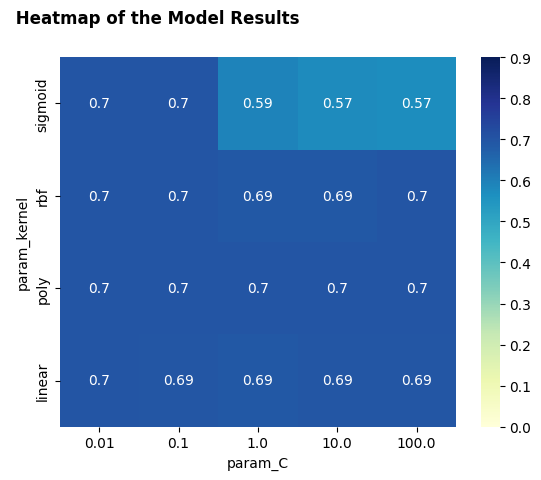

In [13]:
# Plot heatmap
ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.0, vmax=0.9)
ax.invert_yaxis()
plt.suptitle(
    " Heatmap of the Model Results",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

In [14]:
# Train with Tuned SVM
# Create a svm Classifier
clf_tuned = svm.SVC(
    random_state=42,
    C=grid.best_params_["C"],
    kernel=grid.best_params_["kernel"],
    probability=True,
)

clf_tuned.fit(X_train, y_train) # fit tuned SVM to training set

best_svm_model = grid.best_estimator_
# accuracy score on the test data
y_pred = clf_tuned.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(f"Accuracy score of the test data: {accuracy:.4f}")
# Classificaion Report
print(classification_report(y_test, y_pred))

Accuracy score of the test data: 0.6504
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.65      1.00      0.79        80

    accuracy                           0.65       123
   macro avg       0.33      0.50      0.39       123
weighted avg       0.42      0.65      0.51       123



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Neural Networks

### Multi-Layer Perceptron

#Issue 2: Optimizing the Bias-Variance Tradeoff

Reference Equation

Degree 1: Bias^2=34.891, Variance=0.634, MSE=35.525
Degree 3: Bias^2=7.246, Variance=0.156, MSE=7.403
Degree 5: Bias^2=7.016, Variance=0.271, MSE=7.288
Degree 10: Bias^2=7.452, Variance=0.646, MSE=8.098


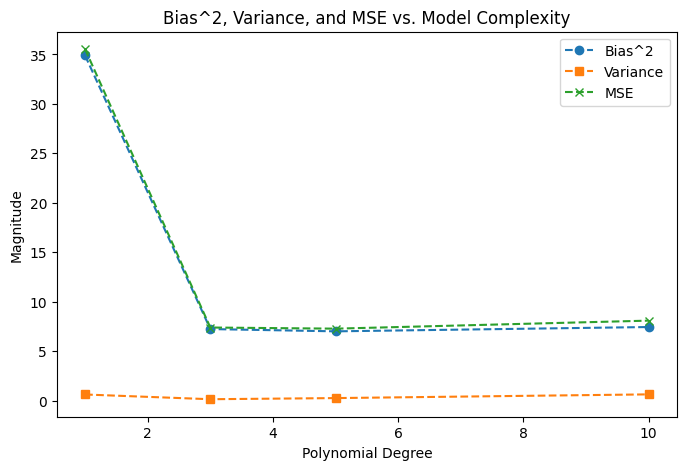

In [24]:
# Demonstrating the Bias-Variance Tradeoff
# using the reference equation:
# MSE = Var(f^(x)) + [Bias(f^(x))]^2 + Var(ε)

# 1. Creating a true function (non-linear) and generating noisy observations
np.random.seed(42)

def true_function(x):
    # A cubic polynomial for demonstration
    return 1.5 * x**3 - 4.0 * x**2 + 2.0 * x - 1.0

# Generating X values and corresponding y_true + noise
X_all = np.linspace(-2.0, 2.0, 200).reshape(-1, 1)
y_true_all = true_function(X_all).ravel()
noise = np.random.normal(loc=0.0, scale=3.0, size=len(X_all))
y_noisy_all = y_true_all + noise

# 2. Training/testing split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_noisy_all, test_size=0.3, random_state=42
)

# 3. Function to approximate bias^2, variance, and MSE
#    We do multiple runs with random re-sampling to estimate these values.
def estimate_bias_variance(degree, runs=50):
    """
    For a specified polynomial 'degree', we:
      1. Randomly re-sample training data multiple times
      2. Train a model on each sample
      3. Record predictions on a fixed test set
      4. Compute average predictions, then derive bias^2, variance, and MSE
    """
    predictions_matrix = []
    # repeated sampling for better approximation
    for _ in range(runs):
        # re-sample the training set
        idx = np.random.randint(0, len(X_train), len(X_train))
        X_sample, y_sample = X_train[idx], y_train[idx]

        # polynomial transform
        poly = PolynomialFeatures(degree=degree)
        X_sample_poly = poly.fit_transform(X_sample)
        X_test_poly = poly.transform(X_test)

        # fit the model
        model = LinearRegression()
        model.fit(X_sample_poly, y_sample)

        # predict on test set
        y_pred = model.predict(X_test_poly)
        predictions_matrix.append(y_pred)

    # Converting to np array for easy aggregation
    predictions_matrix = np.array(predictions_matrix)

    # mean prediction across all runs for each test sample
    mean_predictions = np.mean(predictions_matrix, axis=0)

    # computing bias^2: average[(mean_predictions - y_true)^2]
    # here we use y_test as the "true" labels in the test set
    bias_sq = np.mean((mean_predictions - y_test)**2)

    # computing variance: average of the variance of predictions for each test sample
    # for each test sample i, we find var_i among runs, then average over all i
    var_each_test_point = np.var(predictions_matrix, axis=0)
    variance = np.mean(var_each_test_point)

    # total MSE: mean of all predictions vs. y_test
    # (averaged across runs, but we do it by referencing each run's difference)
    # simpler route: average over all runs, for each run's MSE
    mse_runs = []
    for run_i in range(runs):
        mse_i = np.mean((predictions_matrix[run_i] - y_test)**2)
        mse_runs.append(mse_i)
    mse = np.mean(mse_runs)

    return bias_sq, variance, mse

# 4. Evaluating for various polynomial degrees
degrees = [1, 3, 5, 10]
biases, variances, mses = [], [], []

for deg in degrees:
    b_sq, var, mse_val = estimate_bias_variance(deg, runs=50)
    biases.append(b_sq)
    variances.append(var)
    mses.append(mse_val)
    print(f"Degree {deg}: Bias^2={b_sq:.3f}, Variance={var:.3f}, MSE={mse_val:.3f}")

# 5. Plot results showing how bias^2, variance, and MSE evolve with degree
plt.figure(figsize=(8,5))
plt.plot(degrees, biases, 'o--', label='Bias^2')
plt.plot(degrees, variances, 's--', label='Variance')
plt.plot(degrees, mses, 'x--', label='MSE')
plt.xlabel("Polynomial Degree")
plt.ylabel("Magnitude")
plt.title("Bias^2, Variance, and MSE vs. Model Complexity")
plt.legend()
plt.show()


Approaches to Controlling Bias and Variance

Regularization and Cross-validation

Degree=1: MSE per fold -> [0.02486246 0.04775349 0.03180452 0.0487431  0.07010729], Mean MSE -> 0.045
Degree=4: MSE per fold -> [0.02940225 0.04999149 0.02273009 0.04925371 0.08405904], Mean MSE -> 0.047


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254:

Degree=15: MSE per fold -> [6.54751776e+00 3.78886243e+00 5.60067984e-01 9.85918224e+02
 1.55990874e+02], Mean MSE -> 230.561


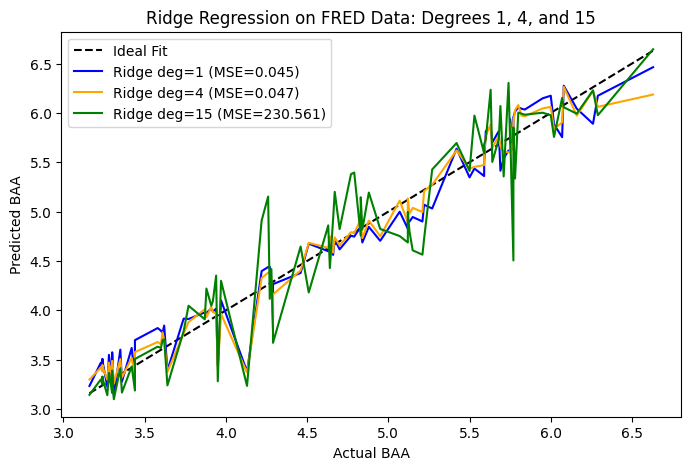

In [25]:
# 1. Fetching data from FRED
fred = Fred(api_key='3085603a10d918d77f7a6789fd1a57ef')

def fetch_fred_data(series_list, start_date, end_date):
    data_holder = {}
    for s in series_list:
        data_holder[s] = fred.get_series(
            s, observation_start=start_date, observation_end=end_date
        )
    df = pd.DataFrame(data_holder)
    return df.dropna()

fred_series = ['FEDFUNDS', 'BAA', 'AAA']
macro_data = fetch_fred_data(fred_series, '2017-11-01', '2025-01-01')

# 2. Set up feature matrix (X) and target vector (y)
X_raw = macro_data[['FEDFUNDS', 'AAA']].values
y = macro_data['BAA'].values

# 3. Polynomial degrees to investigate
degrees = [1, 4, 15]

# 4. Dictionaries for storing predictions and average MSE
predictions_dict = {}
mse_dict = {}

# 5. Looping over polynomial degrees
for deg in degrees:
    # Transform input features
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly = poly.fit_transform(X_raw)

    # Initialize Ridge
    ridge_model = Ridge(alpha=1.0)

    # Cross-validation with MSE
    cv_scores = cross_val_score(
        ridge_model,
        X_poly,
        y,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring='neg_mean_squared_error'
    )
    mse_values = -cv_scores
    avg_mse = mse_values.mean()
    mse_dict[deg] = avg_mse

    # Train on full data
    ridge_model.fit(X_poly, y)
    preds = ridge_model.predict(X_poly)
    predictions_dict[deg] = preds

    print(f"Degree={deg}: MSE per fold -> {mse_values}, Mean MSE -> {avg_mse:.3f}")

# 6. Plotting lines of predictions vs. actual values
plt.figure(figsize=(8, 5))

# Ideal fit line (diagonal)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='Ideal Fit')

colors = ['blue', 'orange', 'green']

# For each degree, sort by actual y so we can draw a line
for i, deg in enumerate(degrees):
    combined = sorted(zip(y, predictions_dict[deg]), key=lambda z: z[0])
    y_sorted, preds_sorted = zip(*combined)
    plt.plot(y_sorted, preds_sorted, color=colors[i],
             label=f'Ridge deg={deg} (MSE={mse_dict[deg]:.3f})')

plt.xlabel("Actual BAA")
plt.ylabel("Predicted BAA")
plt.title("Ridge Regression on FRED Data: Degrees 1, 4, and 15")
plt.legend()
plt.show()


Pruning Decision Trees

Full Tree MSE: 0.049270370370370346
Pruned Tree MSE: 0.044310910675459766


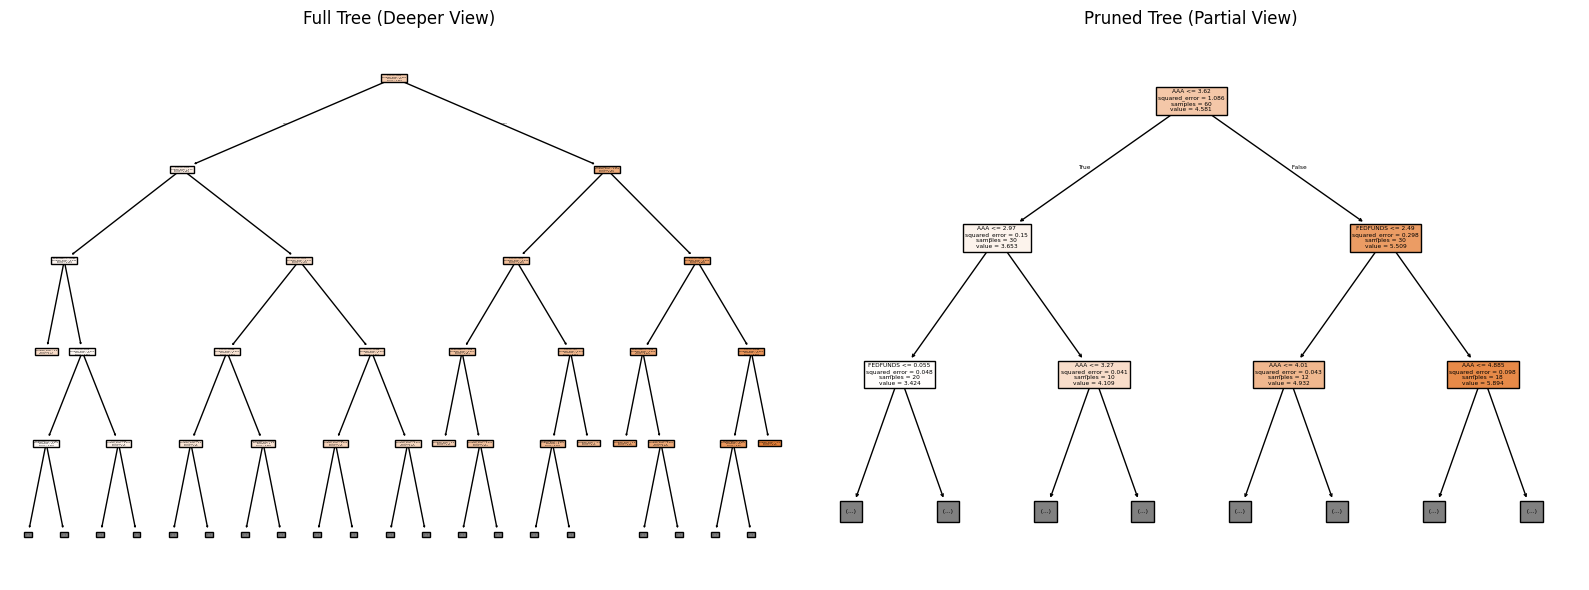

In [26]:
# 1. Fetching and preparing data
fred = Fred(api_key='3085603a10d918d77f7a6789fd1a57ef')
fred_series = ['FEDFUNDS', 'BAA', 'AAA']

def fetch_fred_data(series, start_date, end_date):
    data_dict = {}
    for s in series:
        data_dict[s] = fred.get_series(s, observation_start=start_date, observation_end=end_date)
    df = pd.DataFrame(data_dict)
    return df.dropna()

macro_data = fetch_fred_data(fred_series, '2017-11-01', '2025-01-01')
X = macro_data[['FEDFUNDS','AAA']].values
y = macro_data['BAA'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Fully grown tree
full_tree = DecisionTreeRegressor(max_depth=None, random_state=42)
full_tree.fit(X_train, y_train)

# 3. Pruned tree
pruned_tree = DecisionTreeRegressor(max_depth=3, random_state=42)
pruned_tree.fit(X_train, y_train)

# 4. Evaluate models
print("Full Tree MSE:", np.mean((full_tree.predict(X_test) - y_test)**2))
print("Pruned Tree MSE:", np.mean((pruned_tree.predict(X_test) - y_test)**2))

# 5. Visualizing deeper tree structure
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot_tree(full_tree, max_depth=4, feature_names=['FEDFUNDS','AAA'], filled=True)
plt.title("Full Tree (Deeper View)")

plt.subplot(1, 2, 2)
plot_tree(pruned_tree, max_depth=2, feature_names=['FEDFUNDS','AAA'], filled=True)
plt.title("Pruned Tree (Partial View)")

plt.tight_layout()
plt.show()


Feature Selection

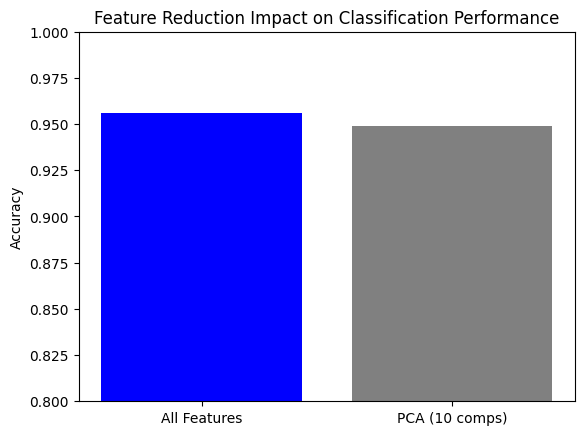

In [27]:
# Load data
data = load_breast_cancer()
X, y = data.data, data.target

# Baseline with all features
rf = RandomForestClassifier(random_state=42)
base_scores = cross_val_score(rf, X, y, cv=5).mean()

# PCA with top 10 components
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)
pca_scores = cross_val_score(rf, X_pca, y, cv=5).mean()

plt.bar(['All Features','PCA (10 comps)'], [base_scores, pca_scores], color=['blue','gray'])
plt.title("Feature Reduction Impact on Classification Performance")
plt.ylabel("Accuracy")
plt.ylim([0.8,1.0])
plt.show()

Early Stopping in Neural Networks

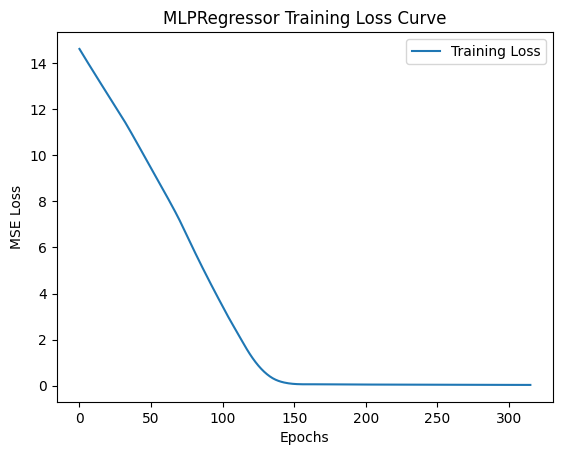

Test MSE: 0.093


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

#Fetch FRED data
def fetch_fred_data(series, start_date, end_date):
    fred = Fred(api_key='3085603a10d918d77f7a6789fd1a57ef')
    data = {}
    for s in series:
        data[s] = fred.get_series(s, observation_start=start_date, observation_end=end_date)
    return pd.DataFrame(data).dropna()

# 1. Prepare data
macro_data = fetch_fred_data(['FEDFUNDS','BAA','AAA'], '2017-11-01', '2025-01-01')
X = macro_data[['FEDFUNDS', 'AAA']].values
y = macro_data['BAA'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Build neural net using MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(16, 8), activation='relu', solver='adam',
                     max_iter=500, early_stopping=True, validation_fraction=0.2, random_state=42)
model.fit(X_train, y_train)

# 3. Plot training and validation loss
plt.plot(model.loss_curve_, label='Training Loss')
plt.title("MLPRegressor Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# 4. Evaluate
y_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse_test:.3f}")


# Issue 3.

## Data Acquisition and Preprocessing

In [29]:
# Define the tickers and FRED series
tickers = ['^GSPC', '^NDX', '^VIX', '^TNX', 'DX-Y.NYB', '^FTSE', '^STOXX50E']

# Define the date range
start_date = '2010-01-01'
end_date = '2025-01-01'

In [30]:
def get_financial_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)['Close']
    return data

def preprocess_data(data):
    # Create multi index
    multi_index_data = pd.DataFrame()
    for col in data.columns:
        temp_df = pd.DataFrame()
        temp_df[('Close',col)] = data[col]
        temp_df[('Return', col)] = data[col].pct_change()
        temp_df[('Volatility', col)] = data[col].pct_change().rolling(window=20).std()
        multi_index_data = pd.concat([multi_index_data,temp_df],axis = 1)
    # Drop rows with NaN from rolling calculations
    multi_index_data.dropna(inplace=True)
    return multi_index_data

In [31]:
data = get_financial_data(tickers, start_date, end_date)
processed_data = preprocess_data(data)

[*********************100%***********************]  7 of 7 completed
<ipython-input-30-0bdc32b8fbd8>:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  temp_df[('Return', col)] = data[col].pct_change()
<ipython-input-30-0bdc32b8fbd8>:12: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  temp_df[('Volatility', col)] = data[col].pct_change().rolling(window=20).std()
<ipython-input-30-0bdc32b8fbd8>:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fi

In [32]:
data

Ticker,DX-Y.NYB,^FTSE,^GSPC,^NDX,^STOXX50E,^TNX,^VIX
Date,,,,,,,
2010-01-04,77.529999,5500.299805,1132.989990,1886.699951,3017.800049,3.841,20.040001
2010-01-05,77.620003,5522.500000,1136.520020,1888.430054,3012.360107,3.755,19.350000
2010-01-06,77.489998,5530.000000,1137.140015,1878.420044,3009.659912,3.808,19.160000
2010-01-07,77.910004,5526.700195,1141.689941,1876.719971,3007.340088,3.822,19.059999
2010-01-08,77.470001,5534.200195,1144.979980,1892.589966,3017.850098,3.808,18.129999
...,...,...,...,...,...,...,...
2024-12-24,108.260002,8137.000000,6040.040039,21797.650391,NaN,4.591,14.270000
2024-12-26,108.129997,NaN,6037.589844,21768.310547,NaN,4.579,14.730000
2024-12-27,108.000000,8149.799805,5970.839844,21473.019531,4898.879883,4.619,15.950000


In [33]:
processed_data

,"(Close, DX-Y.NYB)","(Return, DX-Y.NYB)","(Volatility, DX-Y.NYB)","(Close, ^FTSE)","(Return, ^FTSE)","(Volatility, ^FTSE)","(Close, ^GSPC)","(Return, ^GSPC)","(Volatility, ^GSPC)","(Close, ^NDX)",...,"(Volatility, ^NDX)","(Close, ^STOXX50E)","(Return, ^STOXX50E)","(Volatility, ^STOXX50E)","(Close, ^TNX)","(Return, ^TNX)","(Volatility, ^TNX)","(Close, ^VIX)","(Return, ^VIX)","(Volatility, ^VIX)"
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-01,79.239998,-0.002769,0.004302,5247.399902,0.011352,0.008220,1089.189941,0.014266,0.009905,1760.719971,...,0.012639,2793.290039,0.005928,0.010622,3.654,0.012469,0.012274,22.590000,-0.082453,0.078213
2010-02-02,79.010002,-0.002903,0.004394,5283.299805,0.006841,0.008357,1103.319946,0.012973,0.010401,1776.920044,...,0.012920,2830.010010,0.013146,0.011276,3.635,-0.005200,0.011370,21.480000,-0.049137,0.078707
2010-02-03,79.370003,0.004556,0.004423,5253.200195,-0.005697,0.008349,1097.280029,-0.005474,0.010428,1784.699951,...,0.013008,2804.610107,-0.008975,0.011339,3.703,0.018707,0.011744,21.600000,0.005587,0.078600
2010-02-04,79.919998,0.006930,0.004511,5139.299805,-0.021682,0.009362,1063.109985,-0.031141,0.012218,1732.989990,...,0.014282,2707.449951,-0.034643,0.013280,3.610,-0.025115,0.012813,26.080000,0.207407,0.090147
2010-02-05,80.440002,0.006507,0.004343,5060.899902,-0.015255,0.009633,1066.189941,0.002897,0.012219,1746.119995,...,0.014243,2631.639893,-0.028001,0.014045,3.546,-0.017729,0.013244,26.110001,0.001150,0.088843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,108.410004,0.003518,0.004393,8105.299805,-0.011440,0.005751,5867.080078,-0.000865,0.007901,21110.509766,...,0.011767,4879.000000,-0.015791,0.006613,4.570,0.016911,0.013437,24.090000,-0.127806,0.176376
2024-12-20,107.620003,-0.007287,0.004619,8084.600098,-0.002554,0.004710,5930.850098,0.010869,0.008269,21289.150391,...,0.011886,4862.279785,-0.003427,0.006551,4.524,-0.010066,0.013615,18.360001,-0.237858,0.184305
2024-12-23,108.040001,0.003903,0.004443,8102.700195,0.002239,0.004649,5974.069824,0.007287,0.008413,21503.169922,...,0.012047,4852.930176,-0.001923,0.006568,4.599,0.016578,0.011375,16.780001,-0.086057,0.185365


In [34]:
# Feature and Target Selection
def feature_target_selection(data):
    # Drop 'Close' columns
    close_cols = [col for col in data.columns if col[0] == 'Close']
    features = data.drop(columns=close_cols)

    # Set target
    target = features[('Return', '^GSPC')]

    # Drop target from features
    features = features.drop(columns=[('Return', '^GSPC')])

    # Shift features by one day
    features = features.shift(1)

    # Drop NaN created by shift
    features.dropna(inplace=True)
    target = target.loc[features.index]

    return features, target

In [35]:
features, target = feature_target_selection(processed_data)

In [36]:
# Discretize the target variable (Based on percentiles)
bins = [-float('inf'), -0.01, 0.01, float('inf')]  # Define bins
labels = [0, 1, 2]  # Labels for the bins (negative, neutral, positive)
target_discrete = pd.cut(target, bins=bins, labels=labels, right=False)

### Classes:
Assign a numerical value to each bin.
* Class 0 represents negative returns.
* Class 1 represents neutral returns [-1% - +1%]
* Class 2 represents positive returns.

In [37]:
print("Features:")
features

Features:


,"(Return, DX-Y.NYB)","(Volatility, DX-Y.NYB)","(Return, ^FTSE)","(Volatility, ^FTSE)","(Volatility, ^GSPC)","(Return, ^NDX)","(Volatility, ^NDX)","(Return, ^STOXX50E)","(Volatility, ^STOXX50E)","(Return, ^TNX)","(Volatility, ^TNX)","(Return, ^VIX)","(Volatility, ^VIX)"
Date,,,,,,,,,,,,,
2010-02-02,-0.002769,0.004302,0.011352,0.008220,0.009905,0.011304,0.012639,0.005928,0.010622,0.012469,0.012274,-0.082453,0.078213
2010-02-03,-0.002903,0.004394,0.006841,0.008357,0.010401,0.009201,0.012920,0.013146,0.011276,-0.005200,0.011370,-0.049137,0.078707
2010-02-04,0.004556,0.004423,-0.005697,0.008349,0.010428,0.004378,0.013008,-0.008975,0.011339,0.018707,0.011744,0.005587,0.078600
2010-02-05,0.006930,0.004511,-0.021682,0.009362,0.012218,-0.028974,0.014282,-0.034643,0.013280,-0.025115,0.012813,0.207407,0.090147
2010-02-08,0.006507,0.004343,-0.015255,0.009633,0.012219,0.007577,0.014243,-0.028001,0.014045,-0.017729,0.013244,0.001150,0.088843
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,0.010004,0.004370,0.000476,0.005388,0.008014,-0.035987,0.011704,0.002974,0.005301,0.024857,0.012995,0.740391,0.172908
2024-12-20,0.003518,0.004393,-0.011440,0.005751,0.007901,-0.004659,0.011767,-0.015791,0.006613,0.016911,0.013437,-0.127806,0.176376
2024-12-23,-0.007287,0.004619,-0.002554,0.004710,0.008269,0.008462,0.011886,-0.003427,0.006551,-0.010066,0.013615,-0.237858,0.184305


In [38]:
print("\nTarget Discrete:")
target_discrete


Target Discrete:


,Return
,^GSPC
Date,
2010-02-02,2
2010-02-03,1
2010-02-04,0
2010-02-05,1
2010-02-08,1
...,...
2024-12-19,1
2024-12-20,2


In [39]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(features, target_discrete, test_size=0.2, shuffle=False)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Bagging (Random Forest)

In [40]:
def train_and_evaluate_base_bagmodel(X_train, y_train, X_test, y_test):
    """Trains and evaluates a base Random Forest Classifier."""
    bagmodel = RandomForestClassifier(n_estimators=10, random_state=42)
    bagmodel.fit(X_train, y_train)

    print("Base Bagging (Random Forest) Results:")
    print("Accuracy on train set: %0.4f" % (bagmodel.score(X_train, y_train)))
    print("Accuracy on test set: %0.4f" % (bagmodel.score(X_test, y_test)))

    return bagmodel

In [41]:
# Main Execution - Base
base_bagmodel = train_and_evaluate_base_bagmodel(X_train_scaled, y_train, X_test_scaled, y_test)

Base Bagging (Random Forest) Results:
Accuracy on train set: 0.9834
Accuracy on test set: 0.6533


In [42]:
def tune_hyperparameters_rf(X_train, y_train):
    """Tunes hyperparameters for RandomForest using GridSearchCV."""
    param_grid = {
        "n_estimators": [10],
        "max_depth": [2, 3, 4],
        "min_samples_split": [2, 4, 8],
    }

    grid = GridSearchCV(
        RandomForestClassifier(random_state=42), param_grid, refit=True, verbose=3, cv=3
    )

    grid.fit(X_train, y_train)

    # Get the best model from the grid search
    rf_best_model = grid.best_estimator_

    print("\n---")
    print("Best Random Forest Parameters:")
    print(grid.best_params_)

    return rf_best_model

In [43]:
# Main Execution - Best
best_bagmodel = tune_hyperparameters_rf(X_train_scaled, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END max_depth=2, min_samples_split=2, n_estimators=10;, score=0.770 total time=   0.0s
[CV 2/3] END max_depth=2, min_samples_split=2, n_estimators=10;, score=0.772 total time=   0.0s
[CV 3/3] END max_depth=2, min_samples_split=2, n_estimators=10;, score=0.706 total time=   0.0s
[CV 1/3] END max_depth=2, min_samples_split=4, n_estimators=10;, score=0.770 total time=   0.0s
[CV 2/3] END max_depth=2, min_samples_split=4, n_estimators=10;, score=0.772 total time=   0.0s
[CV 3/3] END max_depth=2, min_samples_split=4, n_estimators=10;, score=0.706 total time=   0.0s
[CV 1/3] END max_depth=2, min_samples_split=8, n_estimators=10;, score=0.770 total time=   0.0s
[CV 2/3] END max_depth=2, min_samples_split=8, n_estimators=10;, score=0.772 total time=   0.0s
[CV 3/3] END max_depth=2, min_samples_split=8, n_estimators=10;, score=0.706 total time=   0.0s
[CV 1/3] END max_depth=3, min_samples_split=2, n_estimators=10;, score=0.770

In [44]:
def evaluate_model(model, X_test, y_test, X_train, y_train):
    """Evaluates the model (classification metrics)."""
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    execution_time = end_time - start_time

    # Classification Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted') #Weighted average to prevent errors.
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Execution Time: {execution_time:.4f} seconds")

    return y_pred

In [45]:
print("\nBase Bagging (Random Forest) Model Results:")
y_pred_base_bag = evaluate_model(base_bagmodel, X_test_scaled, y_test, X_train_scaled, y_train)

print("\n---")

print("\nBest Bagging (Random Forest) Model Results:")
y_pred_best_bag = evaluate_model(best_bagmodel, X_test_scaled, y_test, X_train_scaled, y_train)


Base Bagging (Random Forest) Model Results:
Accuracy: 0.6533
Precision: 0.5466
Recall: 0.6533
F1 Score: 0.5757
Execution Time: 0.0088 seconds

---

Best Bagging (Random Forest) Model Results:
Accuracy: 0.6824
Precision: 0.4657
Recall: 0.6824
F1 Score: 0.5536
Execution Time: 0.0023 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Illustration:

In [46]:
def plot_multiclass_roc(y_test, y_pred_proba, title_prefix=""):
    """Plots both individual and macro-averaged ROC curves."""

    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot individual class ROC curves
    colors = ['red', 'blue', 'green']  # Adjust colors as needed
    for i, color in zip(range(n_classes), colors):
        axes[0].plot(fpr[i], tpr[i], color=color, lw=1,
                     label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
    # Random guess model
    axes[0].plot([0, 1], [0, 1], 'k--', lw=1, label="Random")  # Added label here
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title(f'{title_prefix}Multiclass ROC Curve')
    axes[0].legend(loc="lower right")

    # Plot macro-average ROC curve
    axes[1].plot(fpr_macro, tpr_macro,
                     label='Macro-average ROC curve (AUC = {0:0.2f})'.format(roc_auc_macro),
                     color='navy', linewidth=2)
    # Random guess model
    axes[1].plot([0, 1], [0, 1], 'k--', lw=1, label="Random") # Added label here
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'{title_prefix}Macro-average ROC Curve')
    axes[1].legend(loc="lower right")

    plt.show()

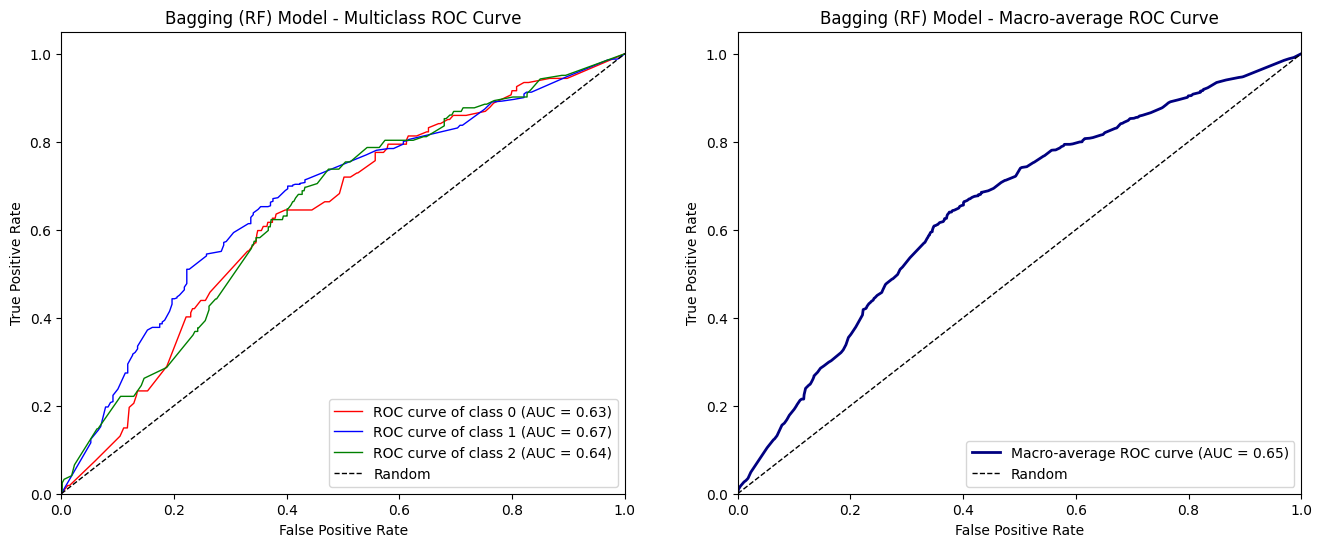

In [47]:
y_pred_proba_bag = best_bagmodel.predict_proba(X_test_scaled)
plot_multiclass_roc(y_test, y_pred_proba_bag, "Bagging (RF) Model - ")

## Boosting (Gradient Boosting)

In [48]:
def train_and_evaluate_base_boostmodel(X_train, y_train, X_test, y_test):
    """Trains and evaluates a base Gradient Boosting Classifier."""
    boostmodel = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    boostmodel.fit(X_train, y_train)

    print("Base Boosting (Gradient Boosting) Results:")
    print("Accuracy on train set: %0.4f" % (boostmodel.score(X_train, y_train)))
    print("Accuracy on test set: %0.4f" % (boostmodel.score(X_test, y_test)))

    return boostmodel

In [49]:
# Main Execution - Base
base_boostmodel = train_and_evaluate_base_boostmodel(X_train_scaled, y_train, X_test_scaled, y_test)

Base Boosting (Gradient Boosting) Results:
Accuracy on train set: 0.8412
Accuracy on test set: 0.6644


In [50]:
def tune_hyperparameters_boost(X_train, y_train):
    """Tunes hyperparameters for Gradient Boosting using GridSearchCV."""
    param_grid = {
        "n_estimators": [10],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 4, 5],
    }

    grid = GridSearchCV(
        GradientBoostingClassifier(random_state=42), param_grid, refit=True, verbose=3, cv=3
    )

    grid.fit(X_train, y_train)

    # Get the best model from the grid search
    boostmodel = grid.best_estimator_

    print("\n---")
    print("Best Gradient Boosting Parameters:")
    print(grid.best_params_)

    return boostmodel

In [51]:
# Main Execution - Best
best_boostmodel = tune_hyperparameters_boost(X_train_scaled, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=10;, score=0.770 total time=   0.4s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=10;, score=0.772 total time=   0.5s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=10;, score=0.772 total time=   0.8s
[CV 1/3] END learning_rate=0.01, max_depth=4, n_estimators=10;, score=0.770 total time=   0.5s
[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=10;, score=0.772 total time=   0.5s
[CV 3/3] END learning_rate=0.01, max_depth=4, n_estimators=10;, score=0.772 total time=   0.5s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=10;, score=0.770 total time=   0.6s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=10;, score=0.772 total time=   0.7s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=10;, score=0.772 total time=   0.7s
[CV 1/3] END learning_rate=0.05, max_depth=3, n_estimators=10;, score=0.770 total tim

In [52]:
print("\nBase Boosting (Gradient Boosting) Model Results:")
y_pred_base = evaluate_model(base_boostmodel, X_test_scaled, y_test, X_train_scaled, y_train)

print("\n---")

print("\nBest Boosting (Gradient Boosting) Model Results:")
y_pred_best = evaluate_model(best_boostmodel, X_test_scaled, y_test, X_train_scaled, y_train)



Base Boosting (Gradient Boosting) Model Results:
Accuracy: 0.6644
Precision: 0.5538
Recall: 0.6644
F1 Score: 0.5711
Execution Time: 0.0066 seconds

---

Best Boosting (Gradient Boosting) Model Results:
Accuracy: 0.6824
Precision: 0.4657
Recall: 0.6824
F1 Score: 0.5536
Execution Time: 0.0019 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Illustration:

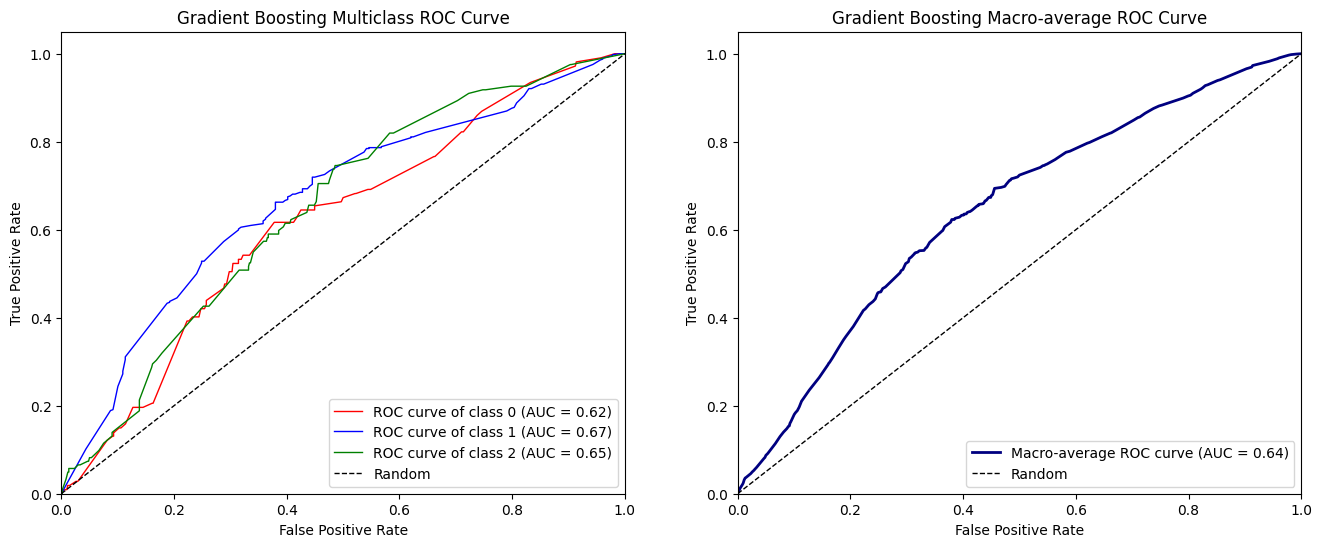

In [53]:
y_pred_proba_boost = best_boostmodel.predict_proba(X_test_scaled)
plot_multiclass_roc(y_test, y_pred_proba_boost, title_prefix="Gradient Boosting ")

## Stacking.

In [54]:
def train_and_evaluate_base_stackmodel(X_train, y_train, X_test, y_test):
    """Trains and evaluates a base Stacking Classifier."""
    estimators = [
        ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, random_state=42))
    ]
    stackmodel = StackingClassifier(estimators=estimators)
    stackmodel.fit(X_train, y_train)

    print("Base Stacking Model Results:")
    print("Accuracy on train set: %0.4f" % (stackmodel.score(X_train, y_train)))
    print("Accuracy on test set: %0.4f" % (stackmodel.score(X_test, y_test)))

    return stackmodel

In [55]:
# Main Execution - Base
base_stackmodel = train_and_evaluate_base_stackmodel(X_train_scaled, y_train, X_test_scaled, y_test)

Base Stacking Model Results:
Accuracy on train set: 0.7718
Accuracy on test set: 0.6824


In [56]:
# Get best parameters
best_rf_params = tune_hyperparameters_rf(X_train_scaled, y_train)
best_gb_params = tune_hyperparameters_boost(X_train_scaled, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END max_depth=2, min_samples_split=2, n_estimators=10;, score=0.770 total time=   0.0s
[CV 2/3] END max_depth=2, min_samples_split=2, n_estimators=10;, score=0.772 total time=   0.0s
[CV 3/3] END max_depth=2, min_samples_split=2, n_estimators=10;, score=0.706 total time=   0.0s
[CV 1/3] END max_depth=2, min_samples_split=4, n_estimators=10;, score=0.770 total time=   0.0s
[CV 2/3] END max_depth=2, min_samples_split=4, n_estimators=10;, score=0.772 total time=   0.0s
[CV 3/3] END max_depth=2, min_samples_split=4, n_estimators=10;, score=0.706 total time=   0.0s
[CV 1/3] END max_depth=2, min_samples_split=8, n_estimators=10;, score=0.770 total time=   0.0s
[CV 2/3] END max_depth=2, min_samples_split=8, n_estimators=10;, score=0.772 total time=   0.0s
[CV 3/3] END max_depth=2, min_samples_split=8, n_estimators=10;, score=0.706 total time=   0.0s
[CV 1/3] END max_depth=3, min_samples_split=2, n_estimators=10;, score=0.770

In [57]:
def tune_hyperparameters_stack(X_train, y_train):
    """Tunes hyperparameters for Stacking Classifier using GridSearchCV, using pre-tuned base models."""
    estimators = [
        ('rf', best_rf_params),
        ('gb', best_gb_params)
    ]
    param_grid = {
        'final_estimator__C': [0.1, 1.0, 10.0],  # Regularization parameter for Logistic Regression
        'final_estimator__solver': ['lbfgs', 'liblinear', 'mylr'],
        'stack_method': ['auto', 'predict_proba']
    }
    stackmodel = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
    grid = GridSearchCV(stackmodel, param_grid, refit=True, verbose=3, cv=3)
    grid.fit(X_train, y_train)

    # Get the best model from the grid search
    stackmodel = grid.best_estimator_

    print("\n---")
    print("Best Stacking Parameters:")
    print(grid.best_params_)

    return stackmodel

In [58]:
# Main Execution - Best
best_stackmodel = tune_hyperparameters_stack(X_train_scaled, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END final_estimator__C=0.1, final_estimator__solver=lbfgs, stack_method=auto;, score=0.770 total time=   3.1s
[CV 2/3] END final_estimator__C=0.1, final_estimator__solver=lbfgs, stack_method=auto;, score=0.772 total time=   5.1s
[CV 3/3] END final_estimator__C=0.1, final_estimator__solver=lbfgs, stack_method=auto;, score=0.772 total time=   4.3s
[CV 1/3] END final_estimator__C=0.1, final_estimator__solver=lbfgs, stack_method=predict_proba;, score=0.770 total time=   3.6s
[CV 2/3] END final_estimator__C=0.1, final_estimator__solver=lbfgs, stack_method=predict_proba;, score=0.772 total time=   2.3s
[CV 3/3] END final_estimator__C=0.1, final_estimator__solver=lbfgs, stack_method=predict_proba;, score=0.772 total time=   2.8s
[CV 1/3] END final_estimator__C=0.1, final_estimator__solver=liblinear, stack_method=auto;, score=0.770 total time=   2.2s
[CV 2/3] END final_estimator__C=0.1, final_estimator__solver=liblinear, sta

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py", line 717, in fit
    return super().fit(X, y_encoded, **fit_params)
          


---
Best Stacking Parameters:
{'final_estimator__C': 0.1, 'final_estimator__solver': 'lbfgs', 'stack_method': 'auto'}


In [59]:
print("\nBase Stacking Model Results:")
y_pred_base = evaluate_model(base_stackmodel, X_test_scaled, y_test, X_train_scaled, y_train)

print("\n---")

print("\nBest Stacking Model Results:")
y_pred_best = evaluate_model(best_stackmodel, X_test_scaled, y_test, X_train_scaled, y_train)


Base Stacking Model Results:
Accuracy: 0.6824
Precision: 0.4663
Recall: 0.6824
F1 Score: 0.5540
Execution Time: 0.0067 seconds

---

Best Stacking Model Results:
Accuracy: 0.6824
Precision: 0.4657
Recall: 0.6824
F1 Score: 0.5536
Execution Time: 0.0041 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Illustration:

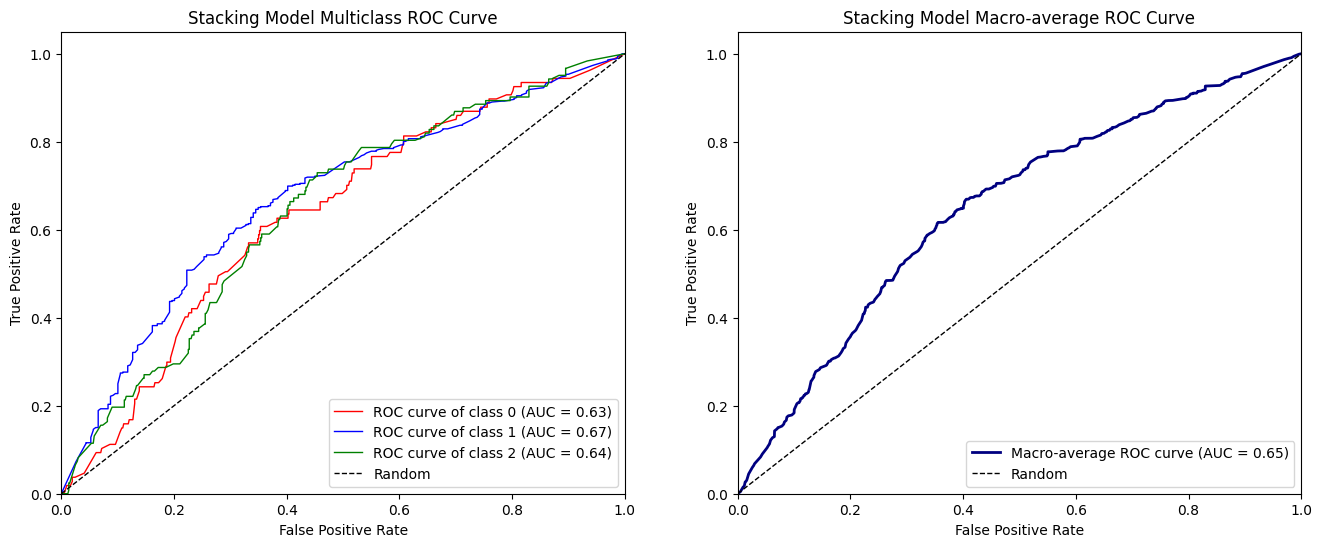

In [60]:
y_pred_proba_stack = best_stackmodel.predict_proba(X_test_scaled)
plot_multiclass_roc(y_test, y_pred_proba_stack, title_prefix="Stacking Model ")

In [61]:
def plot_stacking_rf_gb_roc(best_stackmodel, best_rf_params, best_gb_params, X_test_scaled, y_test, figsize=(10, 6)):
    """Plots the ROC curves for the stacking, Random Forest, and Gradient Boosting models."""

    # Get the parameters from the best_rf_params object
    rf_params = best_rf_params.get_params()
    # Remove 'random_state' from rf_params if it exists to avoid conflict
    rf_params.pop('random_state', None)
    best_bagmodel = RandomForestClassifier(random_state=42, **rf_params).fit(X_train_scaled, y_train)

    # Similarly for GradientBoostingClassifier
    gb_params = best_gb_params.get_params()
    # Remove 'random_state' from gb_params if it exists to avoid conflict
    gb_params.pop('random_state', None)
    best_boostmodel = GradientBoostingClassifier(random_state=42, **gb_params).fit(X_train_scaled, y_train)

    # predicted probabilities generated by tuned classifier
    y_pred_probaStack = best_stackmodel.predict_proba(X_test_scaled)
    y_pred_proba_rf = best_bagmodel.predict_proba(X_test_scaled)
    y_pred_proba_gb = best_boostmodel.predict_proba(X_test_scaled)

    # Stacking Model ROC dependencies
    fpr, tpr, _ = roc_curve(y_test, y_pred_probaStack[:, 1], pos_label=1)
    auc = round(roc_auc_score(y_test, y_pred_probaStack, multi_class='ovr', average='weighted'), 4)

    # Bagging (Random Forest) Model ROC dependencies
    fpr_RF, tpr_RF, _ = roc_curve(y_test, y_pred_proba_rf[:, 1], pos_label=1)
    auc_RF = round(roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr', average='weighted'), 4)

    # Boosting (Gradient Boosting) Model ROC dependencies
    fpr_GB, tpr_GB, _ = roc_curve(y_test, y_pred_proba_gb[:, 1], pos_label=1)
    auc_GB = round(roc_auc_score(y_test, y_pred_proba_gb, multi_class='ovr', average='weighted'), 4)

    plt.figure(figsize=figsize)  # Set the figure size here

    # Bagging (Random Forest) Model
    plt.plot(fpr_RF, tpr_RF, label="RF, auc=" + str(auc_RF), lw=1)
    # Boosting (Gradient Boosting) Model
    plt.plot(fpr_GB, tpr_GB, label="GB, auc=" + str(auc_GB), lw=1)
    # Stacking Model
    plt.plot(fpr, tpr, label="StackM, auc=" + str(auc), lw=1)
    # Random guess model
    plt.plot([0, 1], [0, 1], 'k--', lw=1, label="Random")

    plt.title("ROC")
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.legend(loc=4)
    plt.show()

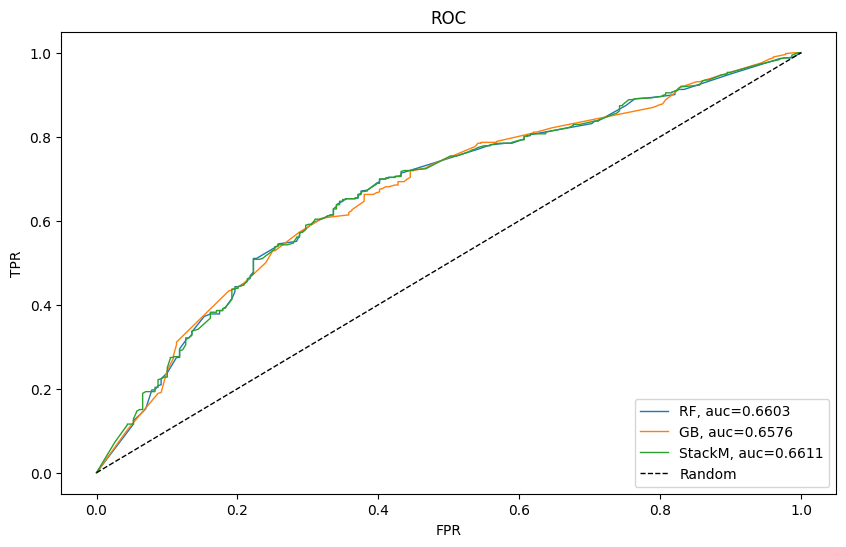

In [62]:
# Plot ROC curves
plot_stacking_rf_gb_roc(best_stackmodel, best_rf_params, best_gb_params, X_test_scaled, y_test)

# Save to PDF

In [ ]:
from google.colab import files
import subprocess

# Upload the notebook file
uploaded = files.upload()

# Specify the notebook name (from the uploaded file)
notebook_name = list(uploaded.keys())[0]
html_name = notebook_name.replace('.ipynb', '.html')

# Convert the notebook to HTML
subprocess.run(["jupyter", "nbconvert", "--to", "html", notebook_name])

# Verify the HTML file is created
!ls /content

# Download the HTML file
files.download(html_name)



Saving MLiF_GWP3_g8507.ipynb to MLiF_GWP3_g8507.ipynb
MLiF_GWP3_g8507.html  MLiF_GWP3_g8507.ipynb  sample_data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>